In [126]:
# Data libraries
import numpy as np
import pandas as pd # for data frame processing

# Tools
import tqdm # We use this to see progress (adds a progressbar to each iterator)
from IPython.display import display_markdown, HTML, Math, display # Formatted output

# Visualisation
#import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Put generic functions in other files (and ask ipython to reload it frequently to work easily)
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import helpers
import optmizer
import plots

In [4]:
runall = False #If false, avoids the long cells

> **Decision-Aid Methodologies for transportation**
>
> Julien ARS (314545) - 23.06.2024

# Statistical Modeling Project

## Task 1-3 : GM car-following model

### Task 1

In [5]:
#Import data

data_I80=pd.read_table('./data/I80_data1.txt')
display(data_I80.head(5))
data_I80[["Speed", "Acceleration", "Space_headway", "Speed_lead"]].describe()

,ID,Time,Position,Length,Width,Type,Speed,Acceleration,Lane,Leader,...,lead04,lane01,lane02,lane03,lane04,tasks,task_index,timelag,dd,idd
0,11,23,69.326102,5.273601,-9999.99,2,5.110310,0.000229,2,1,...,1,1,1,1,1,65,5,22,1,11
1,11,24,74.436263,5.273601,-9999.99,2,5.110201,-0.000140,2,1,...,1,1,1,1,1,65,6,23,1,11
2,11,25,79.463722,5.273601,-9999.99,2,4.717329,-1.677461,2,1,...,1,1,1,1,1,65,7,24,1,11
3,11,26,83.030233,5.273601,-9999.99,2,3.076990,-0.227369,2,1,...,1,1,1,1,1,65,8,25,1,11
4,11,27,86.039234,5.273601,-9999.99,2,2.868391,-0.722239,2,1,...,1,1,1,1,1,65,9,26,1,11


,Speed,Acceleration,Space_headway,Speed_lead
count,15342.000000,15342.000000,15342.000000,15342.000000
mean,8.653950,0.017950,20.954002,8.675547
std,4.206338,0.931255,11.701731,4.266340
min,0.133310,-4.728271,4.216948,0.000000
25%,6.056871,-0.399015,13.493597,6.038846
50%,7.789245,0.002659,17.670935,7.779231
75%,10.176928,0.454691,24.643970,10.190578
max,26.077920,2.892640,118.030033,26.055590


In [6]:
#We reuse the code from lab2, which we have put in another file
from GM_car_following_model import GM_car_following_model

if runall: #avoid running again because it takes time (2 min)
    results={}
    goodness_of_fit = {}
    #For each t_reac, shift the space headway and speed diff of the corresponding time interval
    for t_reac in tqdm.tqdm([0,1,2,3]):
        data = data_I80.copy(deep=True)
        data_shifted = data.groupby("ID").shift(t_reac) # We reuse the fact that the frequence of observation is 1s

        data["Space_headway"] = data_shifted["Space_headway"]
        data["Speed_diff"] = data_shifted["Speed_lead"] - data_shifted["Speed"]

        # Drop na which appeared because of the shift
        data.dropna(inplace=True)

        # Compute the model (verbose=0 to avoid the prints)
        result, kwargs = GM_car_following_model(data=data, model_name=f"GM_t_{t_reac}", verbose=0)
        results[t_reac] = optmizer.calculate_results(result, **kwargs, verbose=0)
        goodness_of_fit[t_reac] = optmizer.calculate_goodness_of_fit(result, **kwargs)

    # Save to not have to rerun it :)
    helpers.save(results, "Task1_results")
    helpers.save(goodness_of_fit, "Task1_gof")


>  - Which of these models best fits the data? Justify your answer.


In [7]:
goodness_of_fit = helpers.load("Task1_gof")
display(helpers.style_gof(pd.DataFrame(list(goodness_of_fit.values()))))

Loading 'pickles/Task1_gof.pickle'


Reaction time,rho squared,adjusted rho squared,AIC,BIC,Log likelihood at zeros:,Initial log likelihood:,Final log likelihood:
0 s,0.03,0.03,40254.35,40330.74,-20752.96,-20752.96,-20117.18
1 s,0.12,0.12,35358.04,35434.15,-20113.41,-20113.41,-17669.02
2 s,0.05,0.05,37222.06,37297.89,-19536.46,-19536.46,-18601.03
3 s,0.02,0.02,37097.91,37173.46,-18963.72,-18963.72,-18538.95



As we can see above, the model that fits best the data based on different goodness-of-fit measures is the one corresponding to a reaction time of 1 second. It has the highest (adjusted) $\rho^2$ measure (while being sufficiently far from 1 that overfitting is unlikely), while having the lowest AIC and BIC values (however, those comparisons are less valuable as each model has the same number of parameters). We also see that the log likelihood is really improved using this model between the initial (or at 0) value and the final value.

> - What do your results imply about the reaction time patterns?

The results implies that the average reaction time of the drivers is near $1\ \mathrm{ sec}$, as that model explains best the response of the drivers.

### Task 2

> Discuss the sign, magnitude, and significance of parameters. To what
range do the explanatory variables affect the dependent variable and in
which way? Discuss what the interpretation of parameters means in
practice.

This is the results of the "best fit" model (reaction time of $1\mathrm{ sec}$) :

In [8]:
results = helpers.load("Task1_results")

level_of_significance = 0.05
display(helpers.show_significance(results[1])) #Showing only insignificant variables

Loading 'pickles/Task1_results.pickle'


Parameter,Estimate,s.e.,t-ratio0,p-value,Rob s.e.,Rob t-ratio0,Rob p-value
alpha_acc,1.536000,0.177000,8.689000,0.000000,0.214000,7.176000,0.000000
alpha_dec,-2.844000,0.353000,-8.045000,0.000000,0.478000,-5.945000,0.000000
beta_acc,0.392000,0.051000,7.712000,0.000000,0.066000,5.935000,0.000000
beta_dec,0.074000,0.045000,1.627000,0.104000,0.051000,1.438000,0.150000
gamma_acc,0.692000,0.053000,13.118000,0.000000,0.070000,9.940000,0.000000
gamma_dec,0.736000,0.059000,12.393000,0.000000,0.073000,10.025000,0.000000
lamda_acc,0.862000,0.033000,26.021000,0.000000,0.033000,25.941000,0.000000
lamda_dec,0.974000,0.036000,26.687000,0.000000,0.044000,22.347000,0.000000
sigma_acc,-0.250000,0.008000,-30.851000,0.000000,0.012000,-20.965000,0.000000
sigma_dec,-0.221000,0.008000,-26.715000,0.000000,0.014000,-16.125000,0.000000


As we can see, the `beta_dec` variable is not sufficient enough (we can not sufficiently prove it is not 0). We will start with updating the models without the variables not sufficient (by setting them to 0).

We will run again the models, but removing the variables that are insignificant

In [9]:
#We reuse the code from lab2, which we have put in another file
from GM_car_following_model import GM_car_following_model


if runall: #avoid running again because it takes time (2 min)
    results={}
    goodness_of_fit = {}
    remove_variables = {}
    #For each t_reac, shift the space headway and speed diff of the corresponding time interval
    for t_reac in (pbar := tqdm.tqdm([0,1,2,3])):
        has_insignificance = True
        res = helpers.load("Task1_results", verbose=0)[t_reac]
        remove_variables[t_reac] = set()
        while has_insignificance: #Loop while a variable has a high p-value
            data = data_I80.copy(deep=True)
            data_shifted = data.groupby("ID").shift(t_reac) # We reuse the fact that the frequence of observation is 1s

            data["Space_headway"] = data_shifted["Space_headway"]
            data["Speed_diff"] = data_shifted["Speed_lead"] - data_shifted["Speed"]

            # Drop na which appeared because of the shift
            data.dropna(inplace=True)

            # Get the name of the variables we need to remove
            remove_variables[t_reac].update(res.loc[res["Rob p-value"] > level_of_significance, "Parameter"])
            pbar.set_description(f"t_reac = {t_reac} ; Removed variables : {remove_variables[t_reac]}")

            # Compute the model (verbose=0 to avoid the prints)
            result, kwargs = GM_car_following_model(
                data=data,
                model_name=f"GM_t_{t_reac}",
                verbose=0,
                remove_variables=remove_variables[t_reac])
            res = optmizer.calculate_results(result, **kwargs, verbose=0)
            goodness_of_fit[t_reac] = optmizer.calculate_goodness_of_fit(result, **kwargs)

            #Compute is it has insignificant variables
            has_insignificance = len(res.loc[res["Rob p-value"] > level_of_significance])>0

        results[t_reac] = res

    # Save to not have to rerun it :)
    helpers.save(results, "Task1_results2")
    helpers.save(goodness_of_fit, "Task1_gof2")

    # Print the removed variables for each model
    {print(f"t = {t}s \t Removed variables : {v}") for t,v in remove_variables.items()} 


In [10]:
goodness_of_fit = helpers.load("Task1_gof")
display_markdown("*With insignificant variables*", raw=True)
display(helpers.style_gof(pd.DataFrame(list(goodness_of_fit.values()))))

goodness_of_fit = helpers.load("Task1_gof2")
display_markdown("*Without insignificant variables*", raw=True)
helpers.style_gof(pd.DataFrame(list(goodness_of_fit.values())))

Loading 'pickles/Task1_gof.pickle'


*With insignificant variables*

Reaction time,rho squared,adjusted rho squared,AIC,BIC,Log likelihood at zeros:,Initial log likelihood:,Final log likelihood:
0 s,0.03,0.03,40254.35,40330.74,-20752.96,-20752.96,-20117.18
1 s,0.12,0.12,35358.04,35434.15,-20113.41,-20113.41,-17669.02
2 s,0.05,0.05,37222.06,37297.89,-19536.46,-19536.46,-18601.03
3 s,0.02,0.02,37097.91,37173.46,-18963.72,-18963.72,-18538.95


Loading 'pickles/Task1_gof2.pickle'


*Without insignificant variables*

Reaction time,rho squared,adjusted rho squared,AIC,BIC,Log likelihood at zeros:,Initial log likelihood:,Final log likelihood:
0 s,0.03,0.03,40252.28,40305.75,-20752.96,-20752.96,-20119.14
1 s,0.12,0.12,35358.77,35427.27,-20113.41,-20113.41,-17670.38
2 s,0.05,0.05,37223.94,37292.20,-19536.46,-19536.46,-18602.97
3 s,0.02,0.02,37097.55,37165.54,-18963.72,-18963.72,-18539.77


We see however that the model with 1s of reaction time is still the best fit to our data. Setting `beta_dec = 0` is equivalent to reworking the model as follows :

*If accelerating :*
$$
\alpha_n(t)=\alpha^{acc} \frac{V_n(t)^{\beta^{acc}}}{\Delta X_n(t)^{\gamma^{acc}}}\left|\Delta V_n\left(t-\tau_n\right)\right|^{\lambda^{acc}}
$$

*If decelerating :*
$$
\alpha_n(t)=\alpha^{dec} \frac{1}{\Delta X_n(t)^{\gamma^{dec}}}\left|\Delta V_n\left(t-\tau_n\right)\right|^{\lambda^{dec}}
$$

As such, removing the dependence on the speed $V_n$ when the leading vehicle is going slower than the current vehicle.

We will now explore the variables values and their implementation. Let's start by looking at the values of the variables :

In [11]:
# Reworking the values to get a dict of parameters :
result = helpers.load("Task1_results2")[1]

parameters = result.set_index("Parameter")["Estimate"].to_dict()
{print(k, v, end="\t" if k[-3:] == "acc" else "\n") for k, v in parameters.items()}

Loading 'pickles/Task1_results2.pickle'
alpha_acc 1.536	alpha_dec -2.756
beta_acc 0.392	gamma_acc 0.692	gamma_dec 0.673
lamda_acc 0.862	lamda_dec 0.966
sigma_acc -0.25	sigma_dec -0.221


{None}

In [12]:
#Print the model with the values
display_markdown("**Accelerating**"
                 f"$$\\alpha_n(t) = {parameters['alpha_acc']} \\cdot \\frac{{V_n(t)^{{{parameters['beta_acc']}}}}}{{\Delta X_n(t)^{{{parameters['gamma_acc']}}}}} \\cdot \\left|\\Delta V_n\\left(t-\\tau_n\\right)\\right|^{{{parameters['lamda_acc']}}}$$",
                 "**Decelerating**"
                 f"$$\\alpha_n(t) = {parameters['alpha_dec']} \\cdot \\frac{{1}}{{\Delta X_n(t)^{{{parameters['gamma_dec']}}}}} \\cdot \\left|\\Delta V_n\\left(t-\\tau_n\\right)\\right|^{{{parameters['lamda_dec']}}}$$",
                 raw=True)

**Accelerating**$$\alpha_n(t) = 1.536 \cdot \frac{V_n(t)^{0.392}}{\Delta X_n(t)^{0.692}} \cdot \left|\Delta V_n\left(t-\tau_n\right)\right|^{0.862}$$

**Decelerating**$$\alpha_n(t) = -2.756 \cdot \frac{1}{\Delta X_n(t)^{0.673}} \cdot \left|\Delta V_n\left(t-\tau_n\right)\right|^{0.966}$$

We can see multiple things :
 - The driver reacts more if he is going faster than the leading vehicle (decelerating case) than in the other case, as expected : $\alpha_{dec} > \alpha_{acc}$
 - The speed of the driver has a relatively low impact on the reaction, even not significant in the decelerating case : $\beta_{acc} << 1$
 - The distance between the 2 vehicles has a similar impact in the accelerating and decelerating case : $\gamma_{acc} \approx \gamma_{dec}$
 - The relative speed has a high impact, even higher in the decelerating case (being near 1, it is near linear): $\lambda_{acc} \rightarrow 1$ and $\lambda_{dec} \rightarrow 1$

We will also, for each beta parameter :
- Make a scatter plot against each of the variables linked to the beta parameter. We will plot for each row the measured acceleration, the estimated acceleration with the full model as well as with a beta value of 0 (equivalent to removing the variable of the model) or 1 (for $\beta and \lambda$ it means a linear model).
- Make a line plot against the same variables. Here, we will plot the result of the model when we consider all other variables constant (at their mean), and similarly to above, with a beta value of 0 or 1.

For the line plot, we will make sure to separate the 2 models (accelerating and decelerating), to have all cases.

In [13]:
# Define the plotter object from plots.py

t_reac = 1
#Recompute data for t_reac = 1
data = data_I80.copy(deep=True)
data_shifted = data.groupby("ID").shift(t_reac) # We reuse the fact that the frequence of observation is 1s

data["Space_headway"] = data_shifted["Space_headway"]
data["Speed_diff"] = data_shifted["Speed_lead"] - data_shifted["Speed"]

# Drop na which appeared because of the shift
data.dropna(inplace=True)


# Create plotter object from the `Plotter` object in `plots.py`
plotter = plots.Plotter(data=data, parameters=parameters)

alpha_acc 1.536	alpha_dec -2.756	

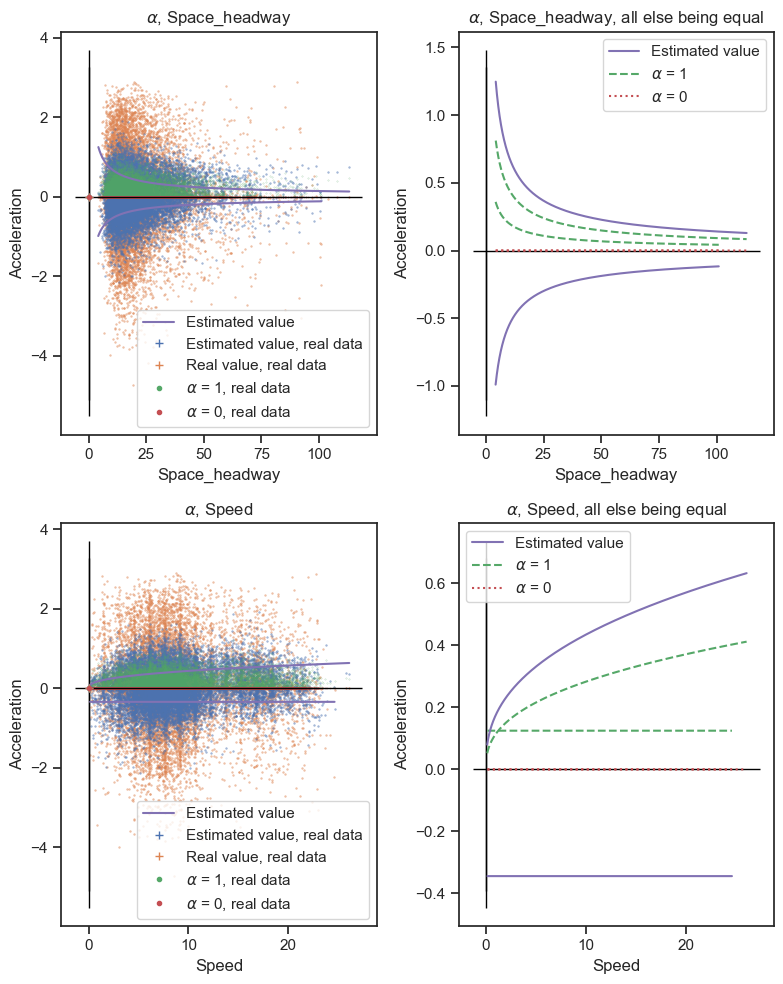

beta_acc 0.392	

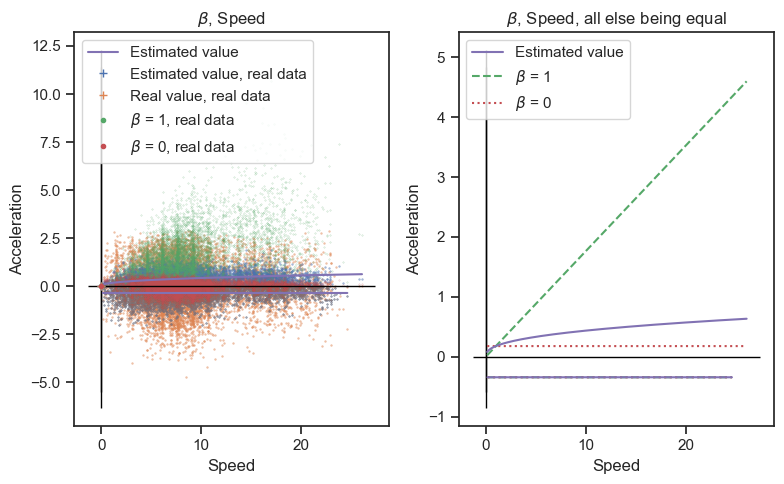

gamma_acc 0.692	gamma_dec 0.673	

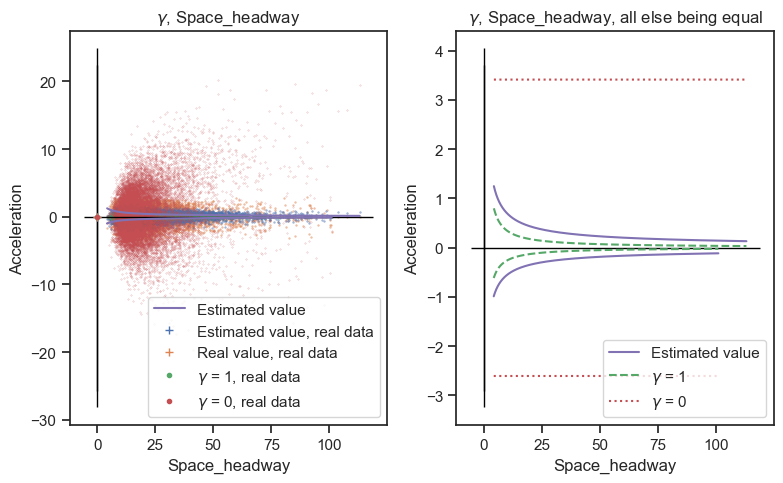

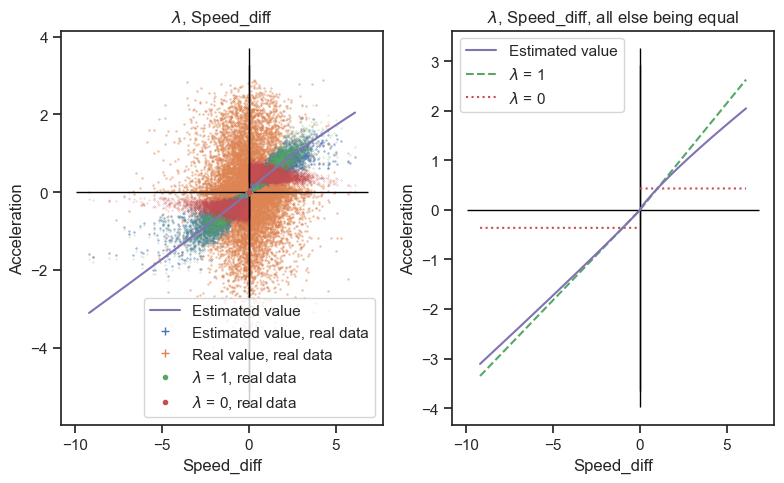

In [14]:
sns.set_theme(style="ticks") # Nice plots

for par in [plots.ALPHA, plots.BETA, plots.GAMMA, plots.LAMBDA]:
    {print(k, v, end="\t") for k, v in parameters.items() if par in k}
    plotter.plot_beta(par)
    plt.show()

### Task 3

> – Use the `US101_data1.txt` and estimate the GM model for reaction time
1s.

In [15]:
#Import `US101_data1.txt`

data_US101=pd.read_table('./data/US101_data1.txt')
display(data_US101.head(5))
data_US101[["Speed", "Acceleration", "Space_headway", "Speed_lead"]].describe()

,ID,Time,Position,Length,Width,Type,Speed,Acceleration,Lane,Leader,...,lead02,lead03,lane01,lane02,lane03,timelag,dd,idd,tasks,task_index
0,13,7,60.454946,4.8768,4.9,2,9.942576,1.319784,2,2,...,1,1,1,1,1,6,1,13,18,5
1,13,8,70.221653,4.8768,4.9,2,8.656320,-3.048000,2,2,...,1,1,1,1,1,7,1,13,18,6
2,13,9,79.595472,4.8768,4.9,2,10.430256,2.063496,2,2,...,1,1,1,1,1,8,1,13,18,7
3,13,10,90.869719,4.8768,4.9,2,11.430000,-0.198120,2,2,...,1,1,1,1,1,9,1,13,18,8
4,13,11,102.175970,4.8768,4.9,2,12.164568,0.594360,2,2,...,1,1,1,1,1,10,1,13,18,9


,Speed,Acceleration,Space_headway,Speed_lead
count,17463.000000,17463.000000,17463.000000,17463.000000
mean,11.618633,0.108080,69.646950,11.811869
std,3.781084,1.531314,21.924084,3.799361
min,0.057912,-3.413760,5.200000,0.000000
25%,9.241536,-0.435864,52.625000,9.531096
50%,12.097512,0.000000,67.420000,12.188952
75%,13.789152,0.734568,85.735000,14.113764
max,23.173944,3.413760,120.000000,28.419552


In [16]:
# Compute the model (similar to task1)
if runall:
    t_reac = 1 #1 second
    data = data_US101.copy(deep=True)
    data_shifted = data.groupby("ID").shift(t_reac) # We reuse the fact that the frequence of observation is 1s

    data["Space_headway"] = data_shifted["Space_headway"]
    data["Speed_diff"] = data_shifted["Speed_lead"] - data_shifted["Speed"]

    # Drop na which appeared because of the shift
    data.dropna(inplace=True)

    # Compute the model (verbose=0 to avoid the prints)
    result, kwargs = GM_car_following_model(data=data, model_name=f"GM_US101_t_{t_reac}", verbose=0)
    results = optmizer.calculate_results(result, **kwargs, verbose=0)
    goodness_of_fit = optmizer.calculate_goodness_of_fit(result, **kwargs)

    # Save to not have to rerun it :)
    helpers.save(results, "Task3_results")
    helpers.save(goodness_of_fit, "Task3_gof")

In [17]:
goodness_of_fit = helpers.load("Task3_gof")
display(helpers.style_gof(pd.DataFrame.from_dict(goodness_of_fit, orient="index", columns=[1]).transpose()))


Loading 'pickles/Task3_gof.pickle'


Reaction time,rho squared,adjusted rho squared,AIC,BIC,Log likelihood at zeros:,Initial log likelihood:,Final log likelihood:
1 s,0.14,0.14,61368.59,61446.02,-35543.59,-35543.59,-30674.29


In [18]:
results = helpers.load("Task3_results")

level_of_significance = 0.05
display(helpers.show_significance(results))

Loading 'pickles/Task3_results.pickle'


Parameter,Estimate,s.e.,t-ratio0,p-value,Rob s.e.,Rob t-ratio0,Rob p-value
alpha_acc,2.422000,0.889000,2.723000,0.006000,0.976000,2.481000,0.013000
alpha_dec,-1.521000,0.791000,-1.923000,0.055000,0.788000,-1.931000,0.054000
beta_acc,0.085000,0.082000,1.038000,0.299000,0.096000,0.888000,0.374000
beta_dec,-0.245000,0.069000,-3.573000,0.000000,0.055000,-4.448000,0.000000
gamma_acc,0.448000,0.104000,4.298000,0.000000,0.124000,3.615000,0.000000
gamma_dec,0.218000,0.147000,1.482000,0.138000,0.143000,1.530000,0.126000
lamda_acc,0.576000,0.045000,12.701000,0.000000,0.050000,11.566000,0.000000
lamda_dec,0.649000,0.065000,9.914000,0.000000,0.064000,10.160000,0.000000
sigma_acc,0.371000,0.007000,51.926000,0.000000,0.010000,37.106000,0.000000
sigma_dec,0.397000,0.008000,47.683000,0.000000,0.011000,35.420000,0.000000


As we can see, we have multiple variables that have a robust p-value higher than 0.05, which means we can not prove their significance in the model. The model can be written as such :

In [19]:
#Print the model with the values
result = helpers.load("Task3_results")

parameters = result.set_index("Parameter")["Estimate"].to_dict()

display_markdown("**Accelerating**"
                 f"$$\\alpha_n(t) = {parameters['alpha_acc']} \\cdot \\frac{{V_n(t)^{{{parameters['beta_acc']}}}}}{{\Delta X_n(t)^{{{parameters['gamma_acc']}}}}} \\cdot \\left|\\Delta V_n\\left(t-\\tau_n\\right)\\right|^{{{parameters['lamda_acc']}}}$$",
                 "**Decelerating**"
                 f"$$\\alpha_n(t) = {parameters['alpha_dec']} \\cdot \\frac{{V_n(t)^{{{parameters['beta_dec']}}}}}{{\Delta X_n(t)^{{{parameters['gamma_dec']}}}}} \\cdot \\left|\\Delta V_n\\left(t-\\tau_n\\right)\\right|^{{{parameters['lamda_dec']}}}$$",
                 raw=True)

Loading 'pickles/Task3_results.pickle'


**Accelerating**$$\alpha_n(t) = 2.422 \cdot \frac{V_n(t)^{0.085}}{\Delta X_n(t)^{0.448}} \cdot \left|\Delta V_n\left(t-\tau_n\right)\right|^{0.576}$$

**Decelerating**$$\alpha_n(t) = -1.521 \cdot \frac{V_n(t)^{-0.245}}{\Delta X_n(t)^{0.218}} \cdot \left|\Delta V_n\left(t-\tau_n\right)\right|^{0.649}$$

We can see that we have different results :
 - The model is different than the precedent, especially in the terms of variables not significant. There are more variables not significant.
 - $\alpha_{dec}$ is lower than previously and \alpha_{acc} higher, which could relate to a bias in the data.
 - The speed of the driver has a very low impact on the reaction, very low in the accelerating case (near 0) and even negative in the decelerating state, which is strange and not really corresponding to what would be expected : $\beta_{acc} \approx 0$, $\beta_{dec} < 0$
 - The distance between the 2 vehicles has a higher impact in the accelerating than in the decelerating case : $\gamma_{acc} < \gamma_{dec}$
 - The relative speed has a high impact, slightly higher in the decelerating case, but lower than previously.

## Task 4 : different locations

> - A researcher, has the results of the model estimated using the
US101_data1.txt data (Location 2). They assume that these results
accurately reflect car-following behaviour at Location 1 too and hence they
are of the opinion that there is no need for a model estimation using the
data of Location 1 (Data I80_data1.txt). Evaluate the suitability of model
results of Location 2 to Location 1. Do you agree with the opinion of the
researcher?

In order to estimate the transferability of the model, we will compare the estimates of the 2 models (before removing any variable) using the following t-test :
$$t_{\text {diff }}=\frac{\beta_k-\beta_{k *}}{\sqrt{\sigma_k^2+\sigma_{k *}^2}}$$

In [37]:
# Loading the models results
result_I80 = helpers.load("Task1_results")[1].set_index("Parameter") #Set Parameter as an index to keep it
result_US101 = helpers.load("Task3_results").set_index("Parameter")

# display(result_I80)
# display(result_US101)

Loading 'pickles/Task1_results.pickle'
Loading 'pickles/Task3_results.pickle'


In [36]:
#Compute t_test
t_test = ((result_I80['Estimate']-result_US101['Estimate'])/np.sqrt(result_I80['Rob s.e.']**2+result_US101['Rob s.e.']**2)).rename("t-test value")
helpers.style_ttest(t_test)

,t-test value
Parameter,
alpha_acc,-0.886722
alpha_dec,-1.435478
beta_acc,2.635217
beta_dec,4.252955
gamma_acc,1.713558
gamma_dec,3.226303
lamda_acc,4.773966
lamda_dec,4.184588
sigma_acc,-39.755451


As we can see there are multiple instances where $\left | \textrm{t-test} \right | > 1.96$. As such, there is a significant difference between the 2 datasets that means we could not apply the same model without updating the parameters. I would therefore not agree with the opinion of the researcher.

## Task 5 : Helly's model

> 1. Use the I80_data1.txt data and estimate Helly’s model for reaction time
1s.

In [56]:
# We have the model in another file
from Helly_car_following_model import Helly_car_following_model

if runall: #avoid running again because it takes time
    results={}
    goodness_of_fit = {}

    t_reac=1
    data = data_I80.copy(deep=True)
    data_shifted = data.groupby("ID").shift(t_reac) # We reuse the fact that the frequence of observation is 1s

    data["Space_headway"] = data_shifted["Space_headway"]
    data["Speed_diff"] = data_shifted["Speed_lead"] - data_shifted["Speed"]
    data["Speed"] = data_shifted["Speed"]

    # Drop na which appeared because of the shift
    data.dropna(inplace=True)

    # Compute the model (verbose=0 to avoid the prints)
    result, kwargs = Helly_car_following_model(data=data, model_name=f"Helly_t_{t_reac}", verbose=0)
    results = optmizer.calculate_results(result, **kwargs, verbose=0)
    goodness_of_fit = optmizer.calculate_goodness_of_fit(result, **kwargs)

    # Save to not have to rerun it :)
    helpers.save(results, "Task5_results")
    helpers.save(goodness_of_fit, "Task5_gof")


Saved to 'pickles/Task5_results.pickle'
Saved to 'pickles/Task5_gof.pickle'


In [57]:
goodness_of_fit = helpers.load("Task5_gof")
display(helpers.style_gof(pd.DataFrame.from_dict(goodness_of_fit, orient="index", columns=[1]).transpose()))


Loading 'pickles/Task5_gof.pickle'


Reaction time,rho squared,adjusted rho squared,AIC,BIC,Log likelihood at zeros:,Initial log likelihood:,Final log likelihood:
1 s,0.11,0.11,35900.91,35938.96,-20113.41,-20113.41,-17945.45


> 2. Discuss the sign, magnitude, and significance of parameters for Helly’s
model. To what range do the explanatory variables affect the dependent
variable and in which way? Discuss what the interpretation of parameters
means in practice.

In [58]:
results = helpers.load("Task5_results")

level_of_significance = 0.05
display(helpers.show_significance(results))

Loading 'pickles/Task5_results.pickle'


Parameter,Estimate,s.e.,t-ratio0,p-value,Rob s.e.,Rob t-ratio0,Rob p-value
alpha1,0.349000,0.005000,66.195000,0.000000,0.012000,29.166000,0.000000
alpha2,0.005000,0.001000,6.965000,0.000000,0.002000,2.779000,0.005000
beta1,-5.118000,3.104000,-1.649000,0.099000,5.398000,-0.948000,0.343000
beta2,2.624000,0.310000,8.471000,0.000000,0.575000,4.563000,0.000000
sigma,-0.217000,0.006000,-37.537000,0.000000,0.011000,-19.851000,0.000000


In [67]:
#Print the model with the values
result = helpers.load("Task5_results")

parameters = result.set_index("Parameter")["Estimate"].to_dict()

display_markdown(f"$$\\begin{{gathered}} \\alpha_n(t)={parameters["alpha1"]} \\Delta V_n\\left(t-\\tau\\right)+{parameters["alpha2"]}\\left[\\Delta X_n\\left(t-\\tau\\right)-\\overline{{\\Delta X}}_n(t)\\right] \\\\ \\overline{{\\Delta X}}_n(t)={parameters["beta1"]}+{parameters["beta2"]} V_n(t-\\tau) \\end{{gathered}} $$",
                 raw=True)

Loading 'pickles/Task5_results.pickle'


$$\begin{gathered} \alpha_n(t)=0.349 \Delta V_n\left(t-\tau\right)+0.005\left[\Delta X_n\left(t-\tau\right)-\overline{\Delta X}_n(t)\right] \\ \overline{\Delta X}_n(t)=-5.118+2.624 V_n(t-\tau) \end{gathered} $$

This model has 3 explanatory variables : the lagged speed difference $\Delta V_n (t-\tau)$, the lagged space headway $\Delta X_n (t-\tau)$ and the lagged speed $V_n(t-\tau)$. We can observe that :
- The robust p-value for the `beta1` parameter is very high, so the significance of this parameter is not proved.
- There is a bigger impact of the speed difference than of the difference between the desired headway and the real headway  : $\alpha_1 << \alpha_2$

In terms of interpretation, we can see that :
- A speed difference of 1 m/s will represent an acceleration of 0.349 m/s.
- The desired space headway increases by 2.624 m for each increase of 1 m/s in the driver's speed.
- The driver will correct the difference between the desired space headway and the real space headway by changing the acceleration, of 0.005 m/s² per meter of difference.

Text(0.5, 0, 'Space headway difference [m]')

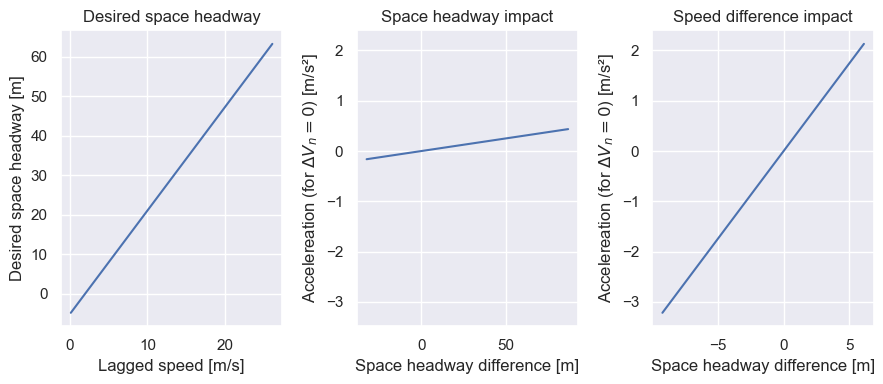

In [85]:
# Plots

sns.set_style("darkgrid")
Vn = np.linspace(data_I80["Speed"].min(), data_I80["Speed"].max(), 2001)
data_space_diff = (data_I80["Space_headway"] - data_I80["Speed"] * parameters["beta2"] - parameters["beta1"])
Space_diff = np.linspace(data_space_diff.min(), data_space_diff.max(), 2001)
data_speed_diff = data_I80["Speed_lead"] - data_I80["Speed"]
Speed_diff = np.linspace(data_speed_diff.min(), data_speed_diff.max(), 2001)

plt.figure(figsize=(9,4), layout="tight")

# Desired headway
plt.subplot(1,3,1)
plt.plot(Vn, parameters["beta1"] + parameters["beta2"] * Vn)
plt.title("Desired space headway")
plt.ylabel("Desired space headway [m]")
plt.xlabel("Lagged speed [m/s]")

ax2 = plt.subplot(1,3,2)
plt.plot(Space_diff, parameters["alpha2"] * Space_diff)
plt.title("Space headway impact")
plt.ylabel("Accelereation (for $\Delta V_n = 0$) [m/s²]")
plt.xlabel("Space headway difference [m]")

plt.subplot(1,3,3, sharey=ax2)
plt.plot(Speed_diff, parameters["alpha1"] * Speed_diff)
plt.title("Speed difference impact")
plt.ylabel("Accelereation (for $\Delta V_n = 0$) [m/s²]")
plt.xlabel("Space headway difference [m]")



> 3. Conceptually, Helly’s model assumes a desired space headway as a
function of lagged speed and two parameters. Do you see any issues with
the specification of the desired headway in terms of using the model for
forecasting? If yes, suggest a potential solution.

## Task 6 : Latent-class car-following model

In [187]:
# Making the model without the space headway
# We have put the code for the model in another file
from Latent_car_following_model import Latent_car_following_model

if True: #avoid running again because it takes time
    results={}
    goodness_of_fit = {}

    t_reac = 1
    data = data_I80.copy(deep=True)
    data_shifted = data.groupby("ID").shift(t_reac) # We reuse the fact that the frequence of observation is 1s

    data["Space_headway"] = data_shifted["Space_headway"]
    data["Speed_diff"] = data_shifted["Speed_lead"] - data_shifted["Speed"]

    # Drop na which appeared because of the shift
    data.dropna(inplace=True)

    
    # Run first without the space headway in the utilities (betas are "b_space_headway_c1" and "b_space_headway_c2" )
    remove_variables = {"b_space_headway_c1", "b_space_headway_c2"}

    # Compute the model (verbose=0 to avoid the prints)
    result, kwargs = Latent_car_following_model(data=data, model_name="Latent", verbose=0, remove_variables=remove_variables)
    results["Relative speed only"] = optmizer.calculate_results(result, **kwargs, verbose=0)
    goodness_of_fit["Relative speed only"] = optmizer.calculate_goodness_of_fit(result, **kwargs)

    # Save to not have to rerun it :)
    helpers.save(results, "Task6_results")
    helpers.save(goodness_of_fit, "Task6_gof")


Saved to 'pickles/Task6_results.pickle'
Saved to 'pickles/Task6_gof.pickle'


In [188]:
result["x"]

array([-2.20644753e-01, -9.55185651e-02,  1.17731926e+00, -1.22233606e+00,
       -3.91794200e-01,  1.29747491e+00,  8.83764779e-01,  2.61846851e-01,
        1.00989631e+00,  1.45160537e+00,  1.44295575e+00,  2.07192076e+00,
       -3.98435183e-04, -9.04038415e-02, -2.78027893e-02, -2.55508442e+00])

In [189]:
results = helpers.load("Task6_results")

level_of_significance = 0.05
display(helpers.show_significance(results["Relative speed only"]))

Loading 'pickles/Task6_results.pickle'


Parameter,Estimate,s.e.,t-ratio0,p-value,Rob s.e.,Rob t-ratio0,Rob p-value
bc_acc,-0.221000,0.057000,-3.872000,0.000000,0.079000,-2.794000,0.005000
bc_dec,-0.096000,0.055000,-1.724000,0.085000,0.074000,-1.286000,0.198000
b_speed_c1,1.177000,0.078000,15.056000,0.000000,0.091000,12.894000,0.000000
b_speed_c2,-1.222000,0.088000,-13.816000,0.000000,0.093000,-13.145000,0.000000
alpha_acc,-0.392000,0.313000,-1.252000,0.210000,0.399000,-0.982000,0.326000
alpha_dec,1.297000,0.319000,4.065000,0.000000,0.383000,3.391000,0.001000
beta_acc,0.884000,0.142000,6.236000,0.000000,0.159000,5.550000,0.000000
beta_dec,0.262000,0.120000,2.189000,0.029000,0.120000,2.191000,0.028000
gamma_acc,1.010000,0.141000,7.176000,0.000000,0.153000,6.600000,0.000000
gamma_dec,1.452000,0.174000,8.361000,0.000000,0.163000,8.911000,0.000000


In [174]:
# Run then with the space headway in the utilities this time
if runall: #avoid running again because it takes time
    results=helpers.load("Task6_results")
    goodness_of_fit = helpers.load("Task6_gof")

    t_reac = 1
    data = data_I80.copy(deep=True)
    data_shifted = data.groupby("ID").shift(t_reac) # We reuse the fact that the frequence of observation is 1s

    data["Space_headway"] = data_shifted["Space_headway"]
    data["Speed_diff"] = data_shifted["Speed_lead"] - data_shifted["Speed"]

    # Drop na which appeared because of the shift
    data.dropna(inplace=True)

    # Get the previous results as betas_start
    betas_start = results["Relative speed only"].set_index("Parameter")["Estimate"].to_dict()
    betas_start["b_space_headway_c1"] = 0   # Add the betas of space headway to the variable 
    betas_start["b_space_headway_c2"] = 0   # Add the betas of space headway to the variable 

    # Compute the model (verbose=0 to avoid the prints)
    result, kwargs = Latent_car_following_model(data=data, model_name="Latent_distance", verbose=0, betas_start=betas_start)
    results["With space headway"] = optmizer.calculate_results(result, **kwargs, verbose=0)
    goodness_of_fit["With space headway"] = optmizer.calculate_goodness_of_fit(result, **kwargs)

    # Save to not have to rerun it :)
    helpers.save(results, "Task6_results")
    helpers.save(goodness_of_fit, "Task6_gof")



Loading 'pickles/Task6_results.pickle'
Loading 'pickles/Task6_gof.pickle'
Saved to 'pickles/Task6_results.pickle'
Saved to 'pickles/Task6_gof.pickle'


In [175]:
goodness_of_fit = helpers.load("Task6_gof")
display(helpers.style_gof(pd.DataFrame(goodness_of_fit).transpose(), index_is_time=False))

Loading 'pickles/Task6_gof.pickle'


,rho squared,adjusted rho squared,AIC,BIC,Log likelihood at zeros:,Initial log likelihood:,Final log likelihood:
Relative speed only,0.43,0.42,14427.26,14549.04,-12538.70,-14208.92,-7197.63
With space headway,0.43,0.43,14393.26,14530.26,-12538.70,-7197.63,-7178.63


> 1. Does adding distance significantly improve model fit? Justify your answer.

In order to know this, we can make a likelihood ratio comparison :
$$ \textrm{LR} = -2 (\textrm{LL}_{restricted} - \textrm{LL}_{unrestricted}) $$

And compare it with the $\chi^2$ test value for 2 degrees of freedom and the level of significance. For a level of significance of $0.05$, the corresponding $\chi^2$ critical value is $5.99$.

In [120]:
LR = -2 * (goodness_of_fit["Relative speed only"]["Final log likelihood:"] - goodness_of_fit["With space headway"]["Final log likelihood:"])
display_markdown(f"$LR = {LR:.2f}$, so the difference is **{'significant' if LR > 5.99 else 'not significant'}**", raw=True)

$LR = 85.20$, so the difference is **significant**

> 2. Discuss the sign, magnitude, and significance of parameters. To what range do the explanatory variables affect the dependent variable and in which way? Discuss what the interpretation of parameters means in practice.

In [ ]:
results = helpers.load("Task6_results")

level_of_significance = 0.05
display(helpers.show_significance(results["With space headway"]))

Loading 'pickles/Task6_results.pickle'


Parameter,Estimate,s.e.,t-ratio0,p-value,Rob s.e.,Rob t-ratio0,Rob p-value
bc_acc,-0.759000,0.097000,-7.811000,0.000000,0.123000,-6.174000,0.000000
bc_dec,-0.519000,0.098000,-5.283000,0.000000,0.112000,-4.617000,0.000000
b_speed_c1,1.247000,0.084000,14.864000,0.000000,0.101000,12.393000,0.000000
b_speed_c2,-1.296000,0.094000,-13.750000,0.000000,0.102000,-12.710000,0.000000
alpha_acc,-0.115000,0.313000,-0.368000,0.713000,0.377000,-0.305000,0.760000
alpha_dec,1.366000,0.316000,4.325000,0.000000,0.370000,3.694000,0.000000
beta_acc,0.869000,0.142000,6.133000,0.000000,0.160000,5.447000,0.000000
beta_dec,0.261000,0.118000,2.202000,0.028000,0.119000,2.201000,0.028000
gamma_acc,1.112000,0.141000,7.892000,0.000000,0.147000,7.546000,0.000000
gamma_dec,1.471000,0.171000,8.600000,0.000000,0.157000,9.355000,0.000000


We see that for 3 variables, we can not prove their significance :
- `alpha_acc` : the main coefficient for the acceleration calculation, in the acceleration case
- `dn` : the utility of the 'do nothing' state
- `sigma_dec` : the standard deviation for the distribution of the acceleration in the deceleration case.

We can now look at the model results :

In [176]:
# Show the models nicely
results = helpers.load("Task6_results")

display_markdown(helpers.show_latent_models(results), raw=True)

Loading 'pickles/Task6_results.pickle'


|Relative speed only|With space headway|
| ---- | ---- |
|*Utilities* $$\begin{gathered} V^{acc} = 0.874 + -1.031 * \Delta V_n(t-\tau)\\ V^{dec} = -4.213 + -1.425 * \Delta V_n(t-\tau)\\ V^{dn} = 0\end{gathered}$$ |*Utilities* $$\begin{gathered} V^{acc} = 1.02 + -1.031 * \Delta V_n(t-\tau) + -0.007 * \Delta X_n(t-\tau)\\ V^{dec} = -4.669 + -1.496 * \Delta V_n(t-\tau) + 0.023 * \Delta X_n(t-\tau)\\ V^{dn} = 0\end{gathered}$$ |
|*Accelerating* $$\alpha_n(t) = -30.607 \cdot \frac{V_n(t)^{7.64}}{\Delta X_n(t)^{-1.512}} \cdot \left\|\Delta V_n\left(t-\tau_n\right)\right\|^{-0.138}$$*Decelerating* $$\alpha_n(t) = 1.392 \cdot \frac{V_n(t)^{0.283}}{\Delta X_n(t)^{1.404}} \cdot \left\|\Delta V_n\left(t-\tau_n\right)\right\|^{1.808}$$|*Accelerating* $$\alpha_n(t) = -33.079 \cdot \frac{V_n(t)^{8.291}}{\Delta X_n(t)^{-1.614}} \cdot \left\|\Delta V_n\left(t-\tau_n\right)\right\|^{-0.143}$$*Decelerating* $$\alpha_n(t) = 1.577 \cdot \frac{V_n(t)^{0.282}}{\Delta X_n(t)^{1.435}} \cdot \left\|\Delta V_n\left(t-\tau_n\right)\right\|^{1.742}$$|
|$\mu_{dn} = 1.16$<br>$\sigma_{acc} = -1.33$<br>$\sigma_{dec} = 0.10$<br>$\sigma_{dn} = -0.52$<br>|$\mu_{dn} = 1.15$<br>$\sigma_{acc} = -1.33$<br>$\sigma_{dec} = 0.09$<br>$\sigma_{dn} = -0.52$<br>|




> 3. Compare the impact of explanatory variables in the acceleration and deceleration with the GM model estimated in Task 1 (for reaction time 1s)

> 4. How do probabilities (of acceleration, deceleration, and do-nothing state) change as a function of the independent variables? Provide a short description.

> 5. Would you recommend the latent class model over the GM model? Which Goodness-of-fit metrics are the most suitable for this comparison and why?